In [1]:
# import packages
import pandas as pd
import datetime
from datetime import timedelta
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import warnings

In [2]:
# mute warnings
warnings.filterwarnings('ignore')

### Read CSV data

In [3]:
# read and inspect user_engagements csv data
engagements = pd.read_csv('relax_challenge/takehome_user_engagement.csv', parse_dates=['time_stamp'])
engagements.info()
engagements

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [4]:
# read and inspect users csv data
users = pd.read_csv('takehome_users.csv', encoding='latin')
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


### Data Wrangling

In [5]:
# set datetime index with timestamp column
engagements.index = engagements.time_stamp

In [6]:
# convert Unix timestamp to datetime
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users.last_session_creation_time = users.last_session_creation_time.fillna(users.creation_time)
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN


### Create Target column

In [7]:
def is_engaged(user):
    
    """
    map function to each user in users table
    takes a user_id
    computes engagement using the engagements table
    returns a boolean
    True -> user active on 3 unique days in a 7 day period
    """
    
    # filter out all other users
    user_eng = engagements[engagements.user_id == user]
   
    # group engagements by day
    user_eng = user_eng.groupby(by=user_eng.time_stamp.dt.date).count()
    
    # sort user engagements by datetime index
    user_eng = user_eng.sort_index()

    # user must have a minimum of 3 days of engagemnt
    if user_eng.shape[0] >= 3:

        # loop through days where user is active
        for i in range(user_eng.shape[0] - 3):
            
            # if current engagement and the 3rd next engagment <= 7 days apart
            adopted = (user_eng.index[i+2] - user_eng.index[i]) <= timedelta(days=7)
            
            # exit the loop if user is engaged
            if adopted:
                return adopted
                
    # return default value         
    return False


# create target colums: map which users have been 'adopted'
users['adopted_user'] = users.object_id.map(is_engaged)

In [8]:
# inspect users dataframe
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,False
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,False
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,False
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,False


### Format data for Lasso and Logistic Regression

In [9]:
# define predictor columns
predictors = ['creation_source', 'creation_time', 
              'last_session_creation_time',
              'opted_in_to_mailing_list', 
              'enabled_for_marketing_drip', 
              'org_id', 'invited_by_user_id']

# define target columns
target = ['adopted_user']

# define columns to one-hot encode
categorical = ['creation_source']

In [10]:
# create dataframe with predictors and targets
lasso_df = users[predictors + target]
lasso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
creation_source               12000 non-null object
creation_time                 12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null bool
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 668.1+ KB


In [11]:
# create boolean column: if user was invited by another user
lasso_df.invited_by_user_id = lasso_df.invited_by_user_id.fillna(0)
lasso_df.invited_by_user_id = (lasso_df.invited_by_user_id > 0) *1

In [12]:
# count users in each organization
org_counts = Counter()
for org in lasso_df.org_id:
    org_counts[org] += 1
    

# create column with total number of users in the user's org
lasso_df['users_in_org'] = lasso_df.org_id.map(org_counts)


# count adopted users in each organization
adopted_users = lasso_df[lasso_df['adopted_user']==1]
org_counts_adopted_users = Counter()
for org in adopted_users.org_id:
    org_counts_adopted_users[org] += 1

# create column with total number of adopted users in the user's org
lasso_df['adopted_users_in_org'] = lasso_df.org_id.map(org_counts_adopted_users)


In [13]:
def replace_with_dummies(df, columns):
    """
    Takes a df and a list of categorial columns with discrete values
    Returns a df with categorical columns replaced with binary columns
    """
    for col in columns:
        temp_df= df[[col]]
        temp_df = pd.get_dummies(temp_df)
        df[temp_df.columns] = temp_df
        df = df.drop(col, axis=1)
    return df

In [14]:
# replace categorical column ['creation_source'] with dummy variables
lasso_df = replace_with_dummies(lasso_df, categorical)
lasso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
creation_time                         12000 non-null object
last_session_creation_time            12000 non-null object
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null int64
adopted_user                          12000 non-null bool
users_in_org                          12000 non-null int64
adopted_users_in_org                  12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: bool(1), int64(6), object(2), uint8(5)
memory usage: 820

In [15]:
# define current day outside of the function for efficiency when mapping

def days_since(date):
    """
    returns the number of days since a given date
    """
    return (current_day - date).days

# create days_since_creation column
lasso_df.creation_time = pd.to_datetime(lasso_df.creation_time)
current_day = lasso_df.creation_time.max()
lasso_df['days_since_creation'] = lasso_df.creation_time.map(days_since)

# create days_since_last_creation column
lasso_df.last_session_creation_time = pd.to_datetime(lasso_df.last_session_creation_time)
current_day = lasso_df.last_session_creation_time.max()
lasso_df['days_since_last_session'] = lasso_df.last_session_creation_time.map(days_since)

# create number of days the user has been active
lasso_df['days_active'] = lasso_df.days_since_creation - lasso_df.days_since_last_session

# drop datetime columns
lasso_df = lasso_df.drop(['creation_time', 'last_session_creation_time'], axis='columns')

# count number of total sessions by the user
lasso_df['total_sessions'] = users.object_id.map(lambda x: engagements[engagements.user_id==x].shape[0])

lasso_df

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,users_in_org,adopted_users_in_org,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,days_since_creation,days_since_last_session,days_active,total_sessions
0,1,0,11,1,False,75,7,1,0,0,0,0,38,45,-7,1
1,0,0,1,1,True,233,15,0,1,0,0,0,196,67,129,14
2,0,0,94,1,False,32,7,0,1,0,0,0,437,443,-6,1
3,0,0,1,1,False,233,15,1,0,0,0,0,374,380,-6,1
4,0,0,193,1,False,16,4,1,0,0,0,0,498,500,-2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,89,1,False,40,6,0,1,0,0,0,266,273,-7,1
11996,0,0,200,0,False,25,2,0,0,0,0,1,505,506,-1,1
11997,1,1,83,1,False,27,5,1,0,0,0,0,33,40,-7,1
11998,0,0,6,0,False,138,10,0,0,1,0,0,729,734,-5,1


### Train Lasso Regression Model

In [16]:
lasso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null int64
adopted_user                          12000 non-null bool
users_in_org                          12000 non-null int64
adopted_users_in_org                  12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
days_since_creation                   12000 non-null int64
days_since_last_session               12000 non-null int64
days_active                           12000 non-null int64
total_s

In [17]:
def train_Lasso(features):
    predictors = lasso_df[features].values
    target = (lasso_df.adopted_user * 1).values

    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=3)
    
    # Identify key features with Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso_coef = lasso.fit(X_train, y_train).coef_
    print(list(lasso_coef))


    _ = plt.figure(figsize=(12,4))
    _ = plt.plot(range(len(features)), lasso_coef, marker='.', linestyle=':')
    _ = plt.xticks(range(len(features)), features, rotation=90)
    _ = plt.ylabel('Coefficients')


In [18]:
def train_classifier(features):
    
    predictors = lasso_df[features].values
    target = (lasso_df.adopted_user * 1).values
    
    scaled_predictors = scale(predictors)

    X_train, X_test, y_train, y_test = train_test_split(scaled_predictors, target, test_size=0.25, random_state=3)
    
    clf = LogisticRegression(solver='lbfgs')
    
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    
    print('model accuracy: ', accuracy_score(predictions, y_test))
    
    return clf, X_test, y_test
    
    

In [19]:
def evaluate_classifier(model, X_test, y_test):
    
    """
    Takes a model and its test data.
    Prints and returns model metrics.
    """
    
    # get predictions
    y_pred = model.predict(X_test)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    # show plot when function is called, plot not returned
    plt.show()   
    
    
    # construct confusion matrix
    conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    conf_matrx.index = ['Actual: NO', 'Actual: YES']
    
    # get classification report
    report = classification_report(y_test, y_pred)
    
    return conf_matrx, report

## Step 1: Explore classifier with only non-correlated predictors

In [20]:
features = lasso_df.drop(['adopted_user','org_id','users_in_org','days_since_creation', 'days_since_last_session', 'days_active', 'total_sessions'], axis='columns').columns
features

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'invited_by_user_id', 'adopted_users_in_org',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

[0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0]


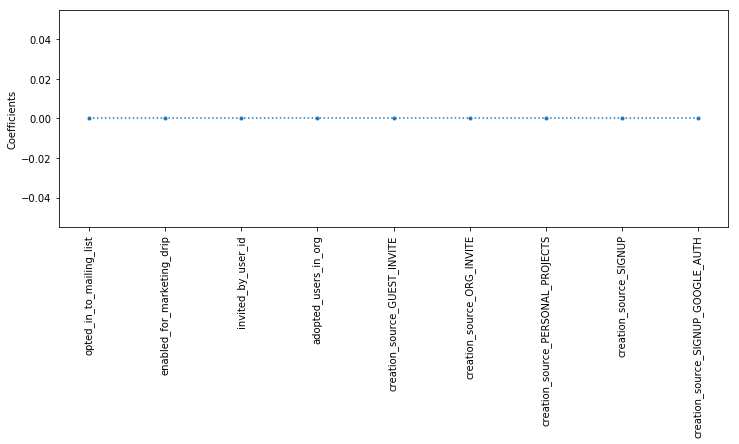

In [21]:
train_Lasso(features)

model accuracy:  0.8596666666666667


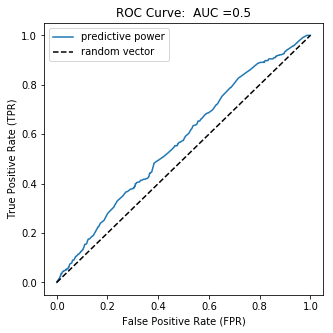

In [22]:
model, X_test, y_test = train_classifier(features)
matrix, report = evaluate_classifier(model, X_test, y_test)

## Step 2: Explore classifier with correlated variables provided in the original dataset

In [23]:
features = lasso_df.drop(['adopted_user','days_since_creation', 'days_since_last_session', 'days_active', 'total_sessions'], axis='columns').columns
features

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'users_in_org', 'adopted_users_in_org',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

[0.0, 0.0, 7.453238607127185e-05, 0.0, -0.0003157139361448454, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0]


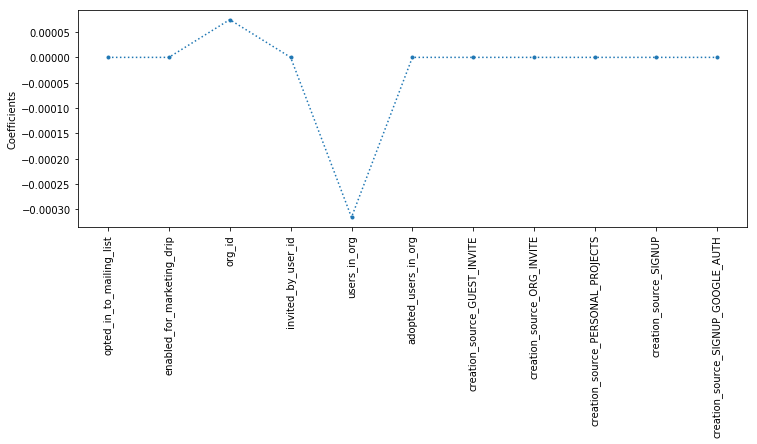

In [24]:
train_Lasso(features)

model accuracy:  0.8596666666666667


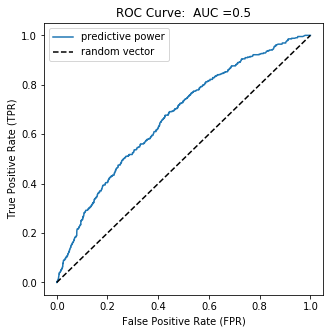

In [25]:
model, X_test, y_test = train_classifier(features)
matrix, report = evaluate_classifier(model, X_test, y_test)

## Step 3: Explore classifier with imputed columns constructed from the original dataset

In [26]:
features = lasso_df.drop(['adopted_user'], axis='columns').columns
features

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'users_in_org', 'adopted_users_in_org',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'days_since_creation',
       'days_since_last_session', 'days_active', 'total_sessions'],
      dtype='object')

[0.0, -0.0, 3.456035213792468e-05, 0.0, -2.0044122084203027e-05, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.00011784886984154982, 0.0033737054452394636, -0.0028142693145812]


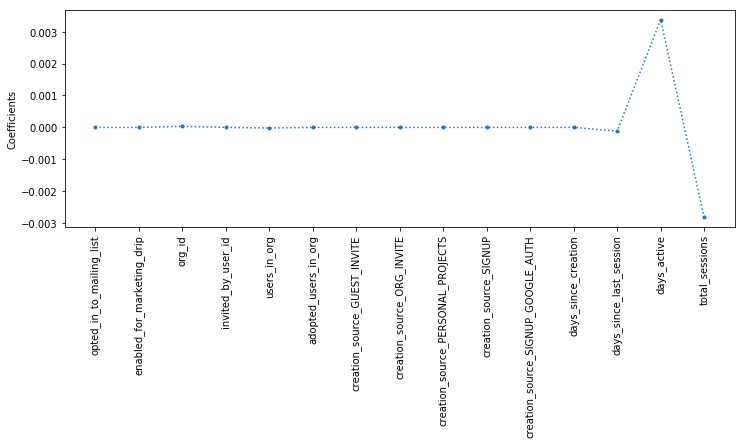

In [27]:
train_Lasso(features)

model accuracy:  0.9783333333333334


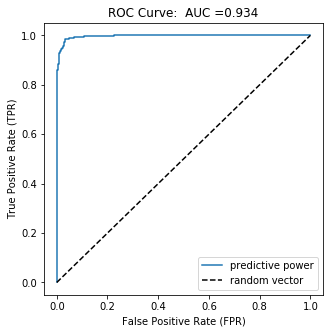

In [28]:
model, X_test, y_test = train_classifier(features)
matrix, report = evaluate_classifier(model, X_test, y_test)